In [1]:
import os
import threading

import numpy as np
import pandas as pd
import xarray as xr
from cmocean import cm
import dask.dataframe as dd

from xhistogram.xarray import histogram

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr



INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.4247819.datarmor0/parcels-502027/libparcels_random_e20a4c75-2ab7-4c59-8d9d-751d9c969370.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=28, processes=14) # necessary?
    w = cluster.scale(jobs=3)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

<Client: 'tcp://10.148.0.22:34689' processes=14 threads=28, memory=111.72 GiB>

---
# Eulerian spectra

!! Requires more processing power: 15 jobs


In [5]:
E_Eulerian = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_lon_lat_xy.zarr'))
E_Eulerian = (E_Eulerian.rename({'lat_bin':'lat_bins', 'lon_bin': 'lon_bins'}))
E_Eulerian

<xarray.Dataset>
Dimensions:         (frequency_band: 4, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'low' 'diurnal' ... 'inertial'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_SSUV          (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(2, 180, 119), meta=np.ndarray>

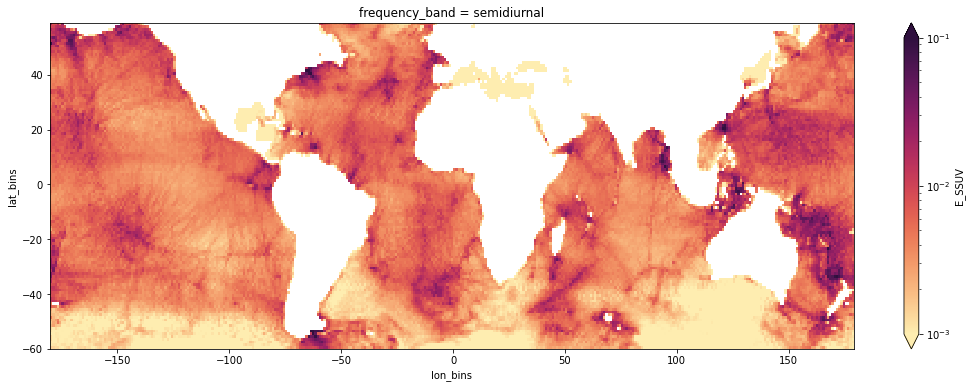

In [6]:
(E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), figsize=(18,6))

# 2. Lagrangian

In [11]:
# load spectra
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'
p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
E_lagrangian = p.load_diagnostic('spectra_lon_lat_bands_L.zarr')
E_lagrangian = E_lagrangian.E
E_lagrangian

<xarray.DataArray 'E' (frequency_band: 4, lon_bins: 359, lat_bins: 119)>
dask.array<xarray-E, shape=(4, 359, 119), dtype=float64, chunksize=(1, 359, 119), chunktype=numpy.ndarray>
Coordinates:
  * frequency_band  (frequency_band) object 'low' 'diurnal' ... 'inertial'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5

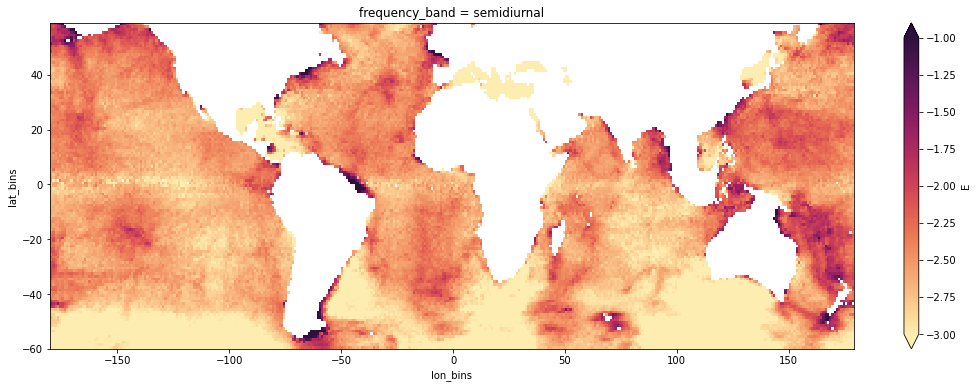

In [12]:
np.log10(E_lagrangian.sel(frequency_band='semidiurnal')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, vmin=-3, vmax=-1, figsize=(18,6))

Text(0.5, 0, '')

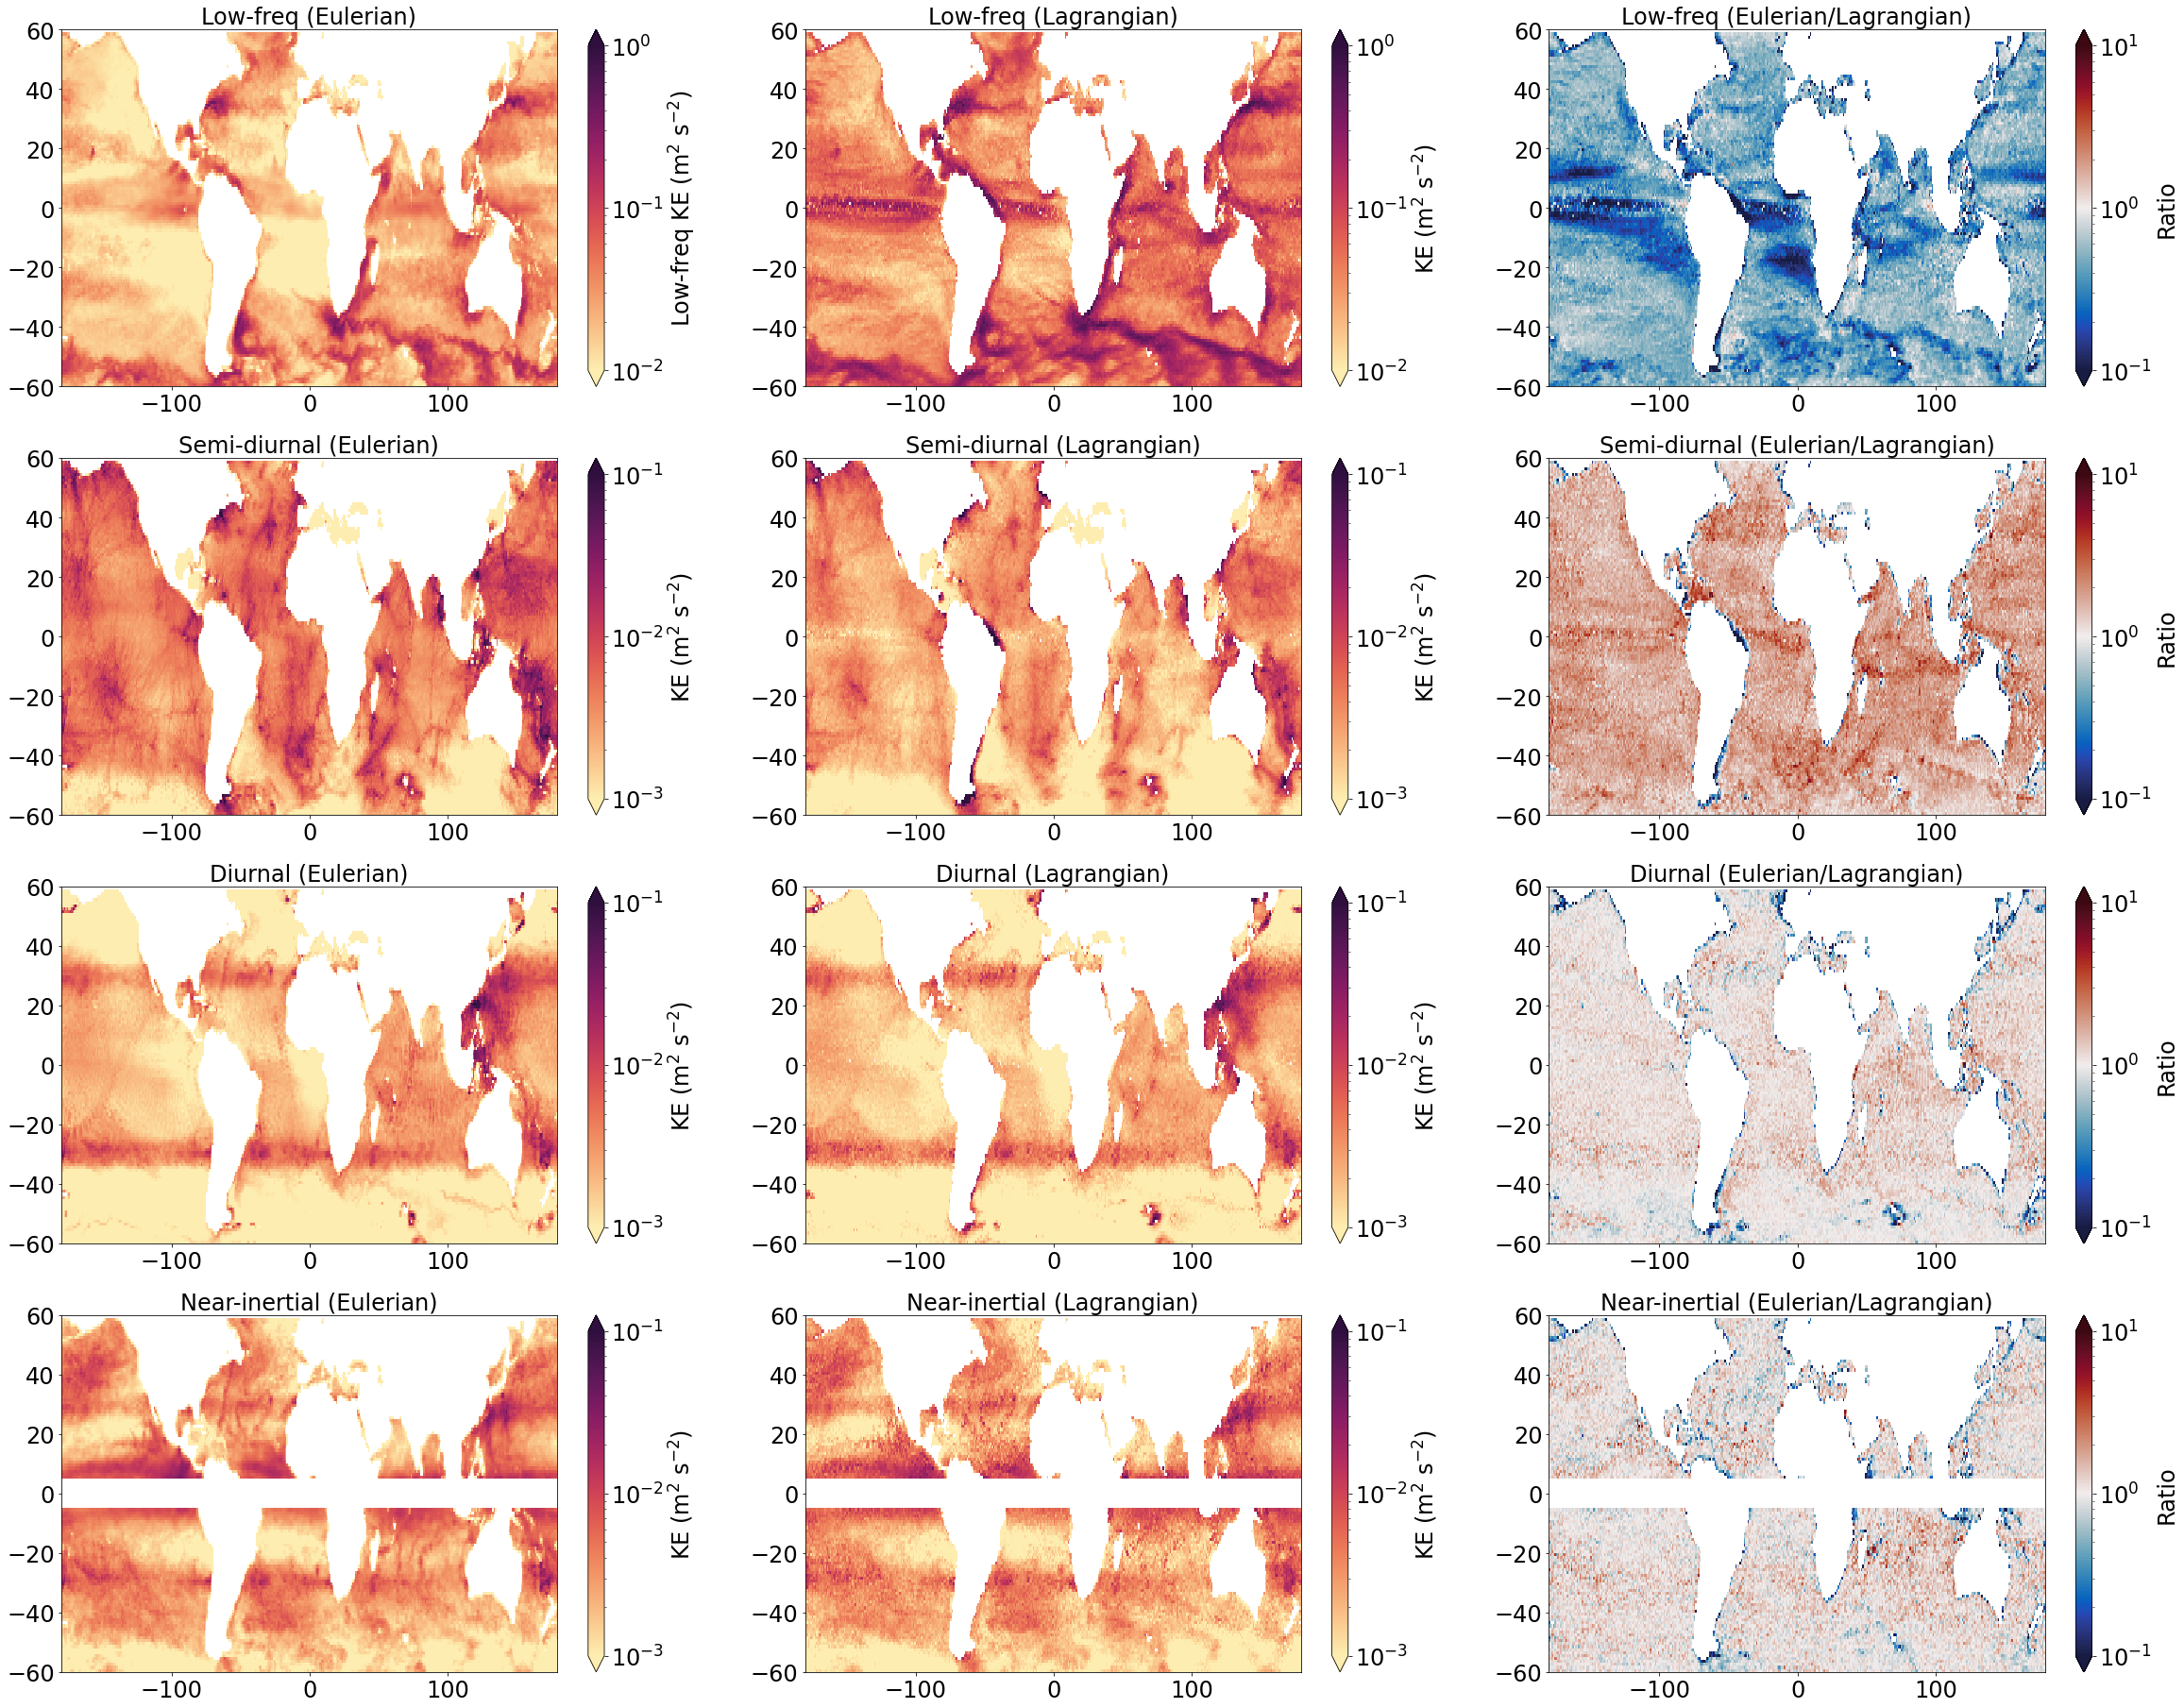

In [31]:
import matplotlib.colors as colors

font_size = 24

fig, ax = plt.subplots(figsize=(40,32))



ax = plt.subplot(431)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Low-freq KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Low-freq (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(434)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(437)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='diurnal')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,10)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='inertial').where(np.abs(E_Eulerian.lat_bins)>5)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)




ax = plt.subplot(432)
cax=(E_lagrangian.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Low-freq (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(435)
cax=(E_lagrangian.sel(frequency_band='semidiurnal')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(438)
cax=(E_lagrangian.sel(frequency_band='diurnal')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,11)
cax=(E_lagrangian.sel(frequency_band='inertial').where(np.abs(E_lagrangian.lat_bins)>5)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)




ax = plt.subplot(433)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='low')/E_lagrangian.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Low-freq (Eulerian/Lagrangian)',fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
cbar.set_label('Ratio', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(436)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal')/E_lagrangian.sel(frequency_band='semidiurnal')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(439)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='diurnal')/E_lagrangian.sel(frequency_band='diurnal')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,12)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='inertial')/E_lagrangian.sel(frequency_band='inertial')).where(np.abs(E_Eulerian.lat_bins)>5).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)


plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC.png')

## Close cluster

In [19]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


---
# Eulerian spectra

!! Requires more processing power: 15 jobs


In [9]:
ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV.zarr'))
#ds = ds.where(ds.Depth>500, drop=False)
#ds = ds.persist()
ds

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 1080, j: 1080)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    mask       (face, j, i) int8 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<chunksize=(1, 24, 72, 1440), meta=np.ndarray>

In [46]:
E_dir = '/home1/scratch/xyu/Spectra/'
open_ocean_depth = 500
E = ds.SSUV
df=E.freq_time[1]-E.freq_time[0]

In [15]:
E_semi = (E.where((abs(E.freq_time)>1.9) & (abs(E.freq_time)<2.1) & (E.Depth>open_ocean_depth), other=0.)*df).sum(dim='freq_time')
E_semi = E_semi.chunk({'i': 1080, 'j': 1080, 'face':1}) 
E_semi = np.real(E_semi).rename('E_semi')
print(E_semi)
file_E = E_dir+'E_semi_1080_open.zarr'
E_semi.to_dataset().to_zarr(file_E, mode='w')  
print('done')

<xarray.DataArray 'E_semi' (face: 13, j: 1080, i: 1080)>
dask.array<real, shape=(13, 1080, 1080), dtype=float64, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    mask     (face, j, i) int8 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
done


In [33]:
E_diurnal = (E.where((abs(E.freq_time)>0.9) & (abs(E.freq_time)<1.1) & (E.Depth>open_ocean_depth), other=0.)*df).sum(dim='freq_time')
E_diurnal = E_diurnal.chunk({'i': 1080, 'j': 1080}) 
E_diurnal = np.real(E_diurnal).rename('E_diurnal')
print(E_diurnal)
file_E = E_dir+'E_diurnal_1080_open.zarr'
E_diurnal.to_dataset().to_zarr(file_E, mode='w')  
print('done')

<xarray.DataArray 'E_diurnal' (face: 13, j: 1080, i: 1080)>
dask.array<real, shape=(13, 1080, 1080), dtype=float64, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    mask     (face, j, i) int8 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
done


In [47]:
f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.YC))
f_cpd_llc = f_llc*86400/2./np.pi
f_cpd_llc = f_cpd_llc.chunk({'i': 72, 'j': 24, 'face':1})

E_f = (E.where((abs(E.freq_time+f_cpd_llc)<0.1) & (E.Depth>open_ocean_depth), other=0.)*df).sum(dim='freq_time')
E_f = E_f.chunk({'i': 1080, 'j': 1080})
E_f = np.real(E_f).rename('E_f')
print(E_f)
file_E = E_dir+'E_f_1080_open.zarr'
E_f.to_dataset().to_zarr(file_E, mode='w')  
print('done')

<xarray.DataArray 'E_f' (face: 13, j: 1080, i: 1080)>
dask.array<real, shape=(13, 1080, 1080), dtype=float64, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
    Depth    (face, j, i) float32 dask.array<chunksize=(13, 1080, 1080), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(13, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(13, 1080, 1080), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    mask     (face, j, i) int8 dask.array<chunksize=(13, 1080, 1080), meta=np.ndarray>
done


# Read band-integrated KE

In [3]:
E_dir = '/home1/scratch/xyu/Spectra/'
E_semi = xr.open_zarr(E_dir+'E_semi_1080_open.zarr')
E_diurnal = xr.open_zarr(E_dir+'E_diurnal_1080_open.zarr')
E_f = xr.open_zarr(E_dir+'E_f_1080_open.zarr')
E_all = xr.merge([E_semi, E_diurnal, E_f])
print(E_all)

<xarray.Dataset>
Dimensions:    (face: 13, i: 1080, j: 1080)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    mask       (face, j, i) int8 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
Data variables:
    E_semi     (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    E_diurnal  (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    E_f        (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>


In [53]:
font_size = 32

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas               
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)                

            #if face in [11,12]:
            #    # this deals with dateline crossing areas
            #    im = vplt.where(vplt.j!=40).plot.pcolormesh(ax=ax,                   
            #                    transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
            #                    x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)     
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                
        cax = plt.axes([0.925, 0.25, 0.025, 0.5])
        cb = plt.colorbar(im, cax=cax, ticks=[-3, -2, -1])
        cb.ax.set_yticklabels(['10$^{-3}$','10$^{-2}$','10$^{-1}$'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        #ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
        #ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
        
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()
            

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell cen

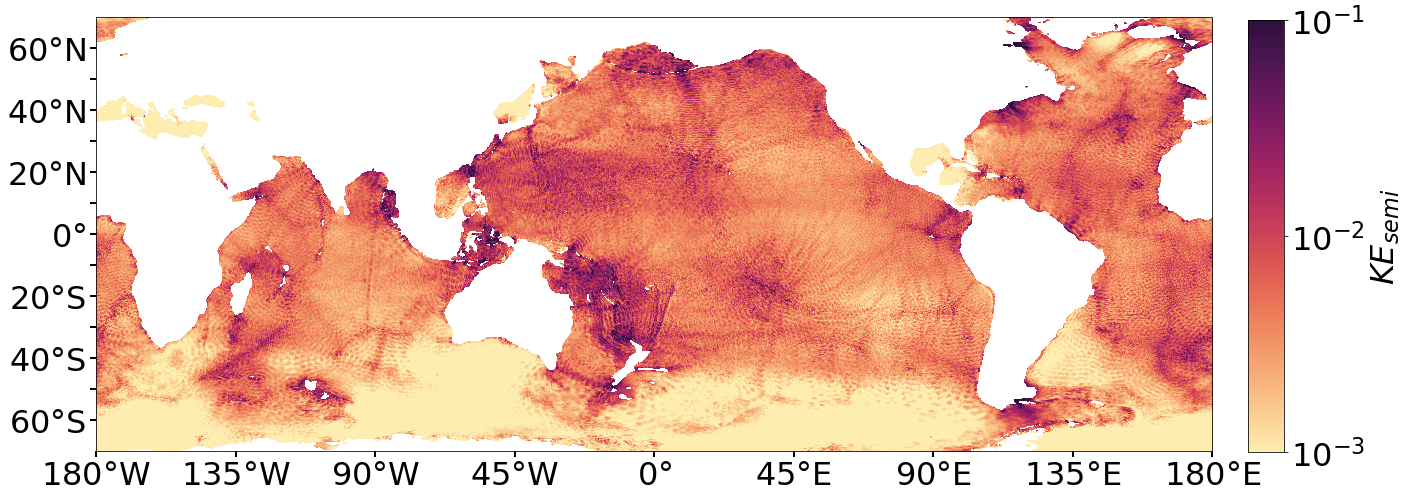

In [57]:
plot_pretty(np.log10(E_all.E_semi), vmin=-3, vmax=-1, label='$KE_{semi}$', cmmap = 'matter', ignore_face=[6])

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell cen

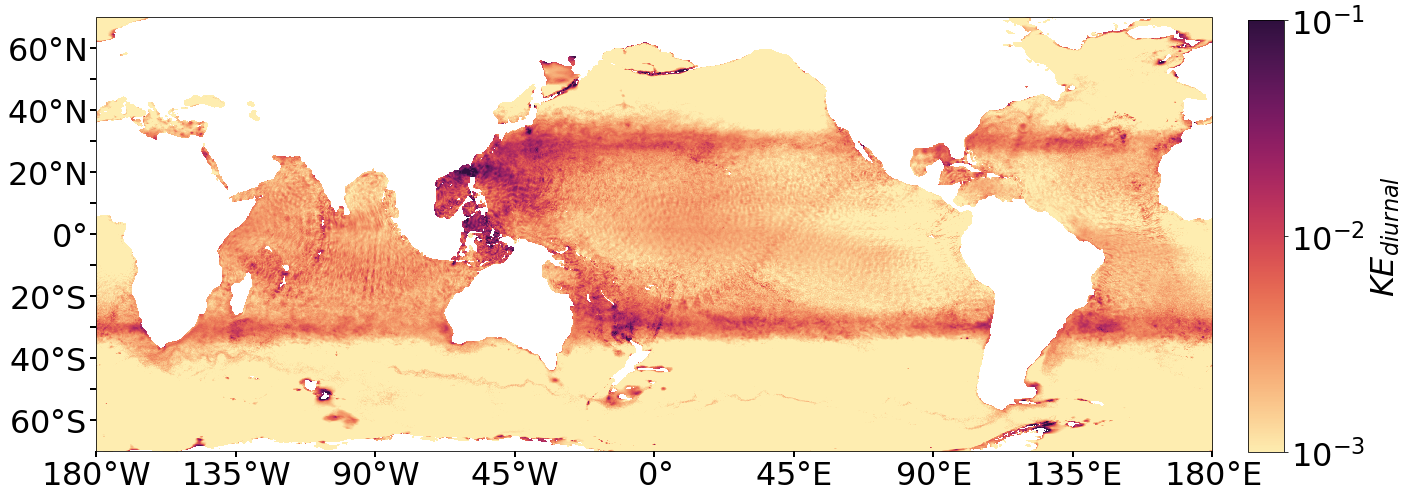

In [55]:
plot_pretty(np.log10(E_all.E_diurnal), vmin=-3, vmax=-1, label='$KE_{diurnal}$', cmmap = 'matter', ignore_face=[6])

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell cen

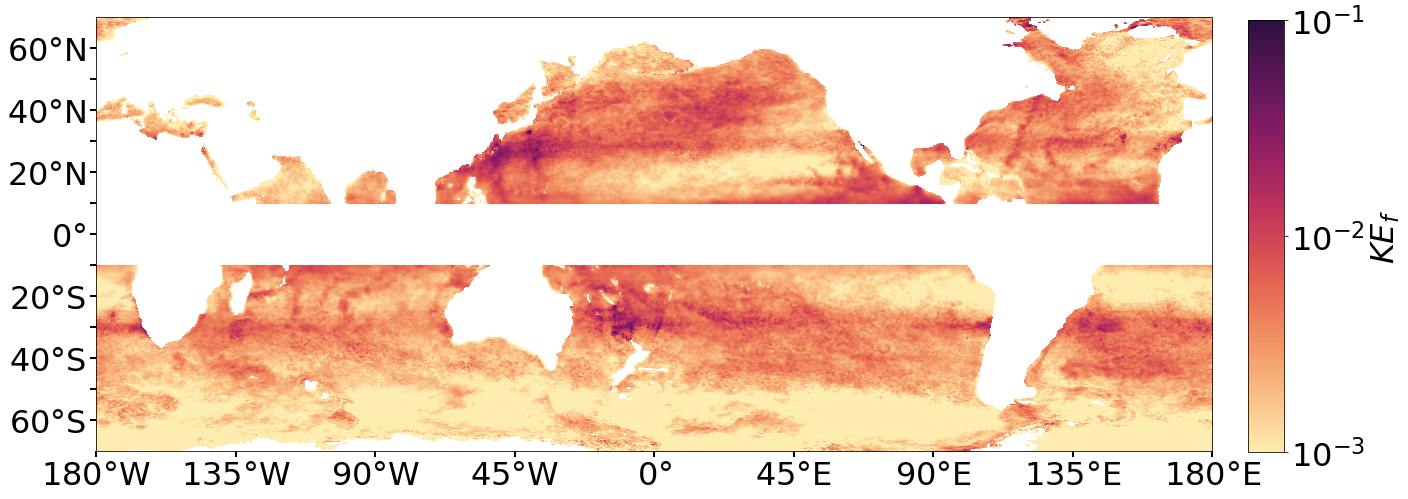

In [56]:
plot_pretty(np.log10(E_all.E_f.where(np.abs(E_all.YC)>10)), vmin=-3, vmax=-1, label='$KE_{f}$', cmmap = 'matter', ignore_face=[6])